<a href="https://colab.research.google.com/github/yinon2592/DL_Project_046211/blob/main/section_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# using https://www.kaggle.com/code/baekseungyun/gpt-2-with-huggingface-pytorch

# initail lr = 1e-5
# we start from 20_000 tweets, after 10 epochs we got into plato
# then we try 100_000 tweets for 1 epoch and got 0.04 val improvement
# then we try 500_000 tweets for 1 epoch and got 0.08 val improvement
# now we try lr = 1e-3


# we use data for training in section_a (classifier) and section_c (fine tunning with sentiments), therfore we will split the data for each data separately
# we use data for testing to compare "reverce sentiment capability" of prompt engineering(section_b) with raw gpt2 vs the finetuned one(section_c), therfore we will use the same validation set for this part

In [2]:
from google.colab import drive
# drive.mount('/content/drive/my-drive/project_calculations')
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install transformers
from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification
import os
import pandas as pd
from torch.utils.data import Dataset
import re
import torch

set_seed(731) # My Birthday!, you should get train_loss: 0.773, train_acc: 0.567 in epoch 0.

model_config = GPT2Config.from_pretrained('gpt2', num_labels=2) # Binary Classification
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)

model_path = '/content/drive/My Drive/project_calculations/model.pth'
if os.path.exists(model_path):
  print("loading last model parameters..")
  model.load_state_dict(torch.load(model_path))

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left" # Very Important
tokenizer.pad_token = tokenizer.eos_token

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.0 MB/s eta 0:00:00


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loading last model parameters..


In [4]:
# Step 1: Dataset Preparation
# load section_a data (data already cleaned)
section_a_data_path = '/content/drive/My Drive/project_dataset/section_a_data.csv'
df = pd.read_csv(section_a_data_path)
df = df.sample(500_000, random_state=1)
print(df.label.value_counts())
print(df.sample(16))

class TweetDataset(Dataset):
    def __init__(self, train=True):
        super().__init__()
        self.train = train
        # self.data = pd.read_csv(os.path.join('/kaggle/input/nlp-getting-started/', 'train.csv' if train else 'test.csv'))
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        record = self.data.iloc[index]
        text = record['text']
        if self.train:
            return {'text': text, 'label': record['label']}
        else:
            return {'text': text, 'label': '0'}

train_dataset = TweetDataset(train=True)
test_dataset = TweetDataset(train=False)

0    250017
1    249983
Name: label, dtype: int64
        label                                               text
49307       1               i want to travel for the world ahaha
87924       0  is having the last breakfast in vietnam and ge...
233050      0       ok so something just bit my lip not pleasant
278560      1                   hospital drugs are my friend lol
96584       0            oh my god i just chipped my front tooth
471557      1                                 din din and movies
350560      1  www youtube com titomi15 watch the videos comm...
281231      0   awwww can u tweet me the pic cuz i didn t see it
321235      1  i now have seasons 7 and 8 of whose line is it...
283689      0  can you get catacombs ffrom the cinemas i trie...
301880      1  baking my french bread now it looks good i mig...
174237      0  daya i wanna go to the sale wanna horde topsho...
276852      1  the tv has its own way of attracting me especi...
57396       0  really could go for a moc

In [5]:
class Gpt2ClassificationCollator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        inputs = self.tokenizer(text=texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True,
                                max_length=self.max_seq_len)
        inputs.update({'labels': torch.tensor(labels)})

        return inputs

gpt2classificationcollator = Gpt2ClassificationCollator(tokenizer=tokenizer,
                                                        max_seq_len=60)

In [6]:
from torch.utils.data import DataLoader, random_split

train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
# Splitting the data deterministically
train_dataset = df[:train_size]
val_dataset = df[train_size:train_size+val_size]
# train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True,
                              collate_fn=gpt2classificationcollator)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=32,
                            shuffle=False,
                            collate_fn=gpt2classificationcollator)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             collate_fn=gpt2classificationcollator)

In [7]:
from transformers import AdamW, get_cosine_schedule_with_warmup

total_epochs = 1

print(model)

last_layers_names =[
  'transformer.h.11.mlp.c_fc.weight',
  'transformer.h.11.mlp.c_fc.bias',
  'transformer.h.11.mlp.c_proj.weight',
  'transformer.h.11.mlp.c_proj.bias',
  'transformer.ln_f.weight',
  'transformer.ln_f.bias',
  'score.weight'
]

# Set require_grad to False for all levels except the last one
parameters = []
for name, param in model.named_parameters():
  # print("name = ", name, " ", "type = ", type(name), " ", "param = ", param)
  if not name in last_layers_names:  # Exclude parameters of the last layer
    param.requires_grad = False
  else:
    print("name = ", name)
    param.requires_grad = True
    parameters.append(param)



# param_optimizer = list(model.named_parameters() model.score.parameters())
# no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
# ]
# optimizer = AdamW(optimizer_grouped_parameters,
#                   lr=1e-5,
#                   eps=1e-8)





# print("model.classifier.parameters() = ", model.classifier.parameters())

# param_optimizer = {'params': list(model.score.parameters())}

# print(param_optimizer)
# no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
# ]
# print(list(model.parameters()))

# Get the parameters of the model that require gradients
# parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
# parameters = [param for name, param in model.named_parameters() if param.requires_grad]
# print("parameters = ", parameters)

# params = [param for name, param in model.named_parameters() if param.requires_grad]
# print(model.named_parameters())
optimizer = AdamW(parameters,
                  lr=1e-3,
                  eps=1e-8)

num_train_steps = len(train_dataloader) * total_epochs
num_warmup_steps = int(num_train_steps * 0.1)

lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                               num_warmup_steps=num_warmup_steps,
                                               num_training_steps = num_train_steps)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)
name =  transformer.h.11.mlp.c_fc.weight
name =  transformer.h.11.mlp.c_fc.bias
name =  transformer.h.11

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
import torch

def train(dataloader, optimizer, scheduler, device_):
    global model
    model.train()

    prediction_labels = []
    true_labels = []

    total_loss = []

    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}


        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent exploding gradient

        optimizer.step()
        scheduler.step()

        prediction_labels += logits.argmax(axis=-1).flatten().tolist()

    return true_labels, prediction_labels, total_loss

def validation(dataloader, device_):
    global model
    model.eval()

    prediction_labels = []
    true_labels = []

    total_loss = []

    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss.append(loss.item())

            prediction_labels += logits.argmax(axis=-1).flatten().tolist()

    return true_labels, prediction_labels, total_loss

In [9]:
from sklearn.metrics import classification_report, accuracy_score
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

best_val = -float('inf')

for epoch in range(total_epochs):

    start_time = time.time()  # Start the timer

    y, y_pred, train_loss = train(train_dataloader, optimizer, lr_scheduler, device)
    train_acc = accuracy_score(y, y_pred)

    y, y_pred, val_loss = validation(val_dataloader, device)
    val_acc = accuracy_score(y, y_pred)

    all_loss['train_loss'] += train_loss
    all_loss['val_loss'] += val_loss

    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

    end_time = time.time()  # Stop the timer
    epoch_duration = end_time - start_time

    if val_acc > best_val:
      best_val = val_acc
      # Save your model to Google Drive
      print(" current best val is ",best_val)
      torch.save(model.state_dict(), '/content/drive/My Drive/project_calculations/model.pth')

    print(f"Epoch: {epoch}, Train Loss: {torch.tensor(train_loss).mean():.3f}, Train Acc: {train_acc:.3f}, Val Loss: {torch.tensor(val_loss).mean():.3f}, Val Acc: {val_acc:.3f}, Epoch Duration: {epoch_duration:.3f} seconds")



KeyError: ignored

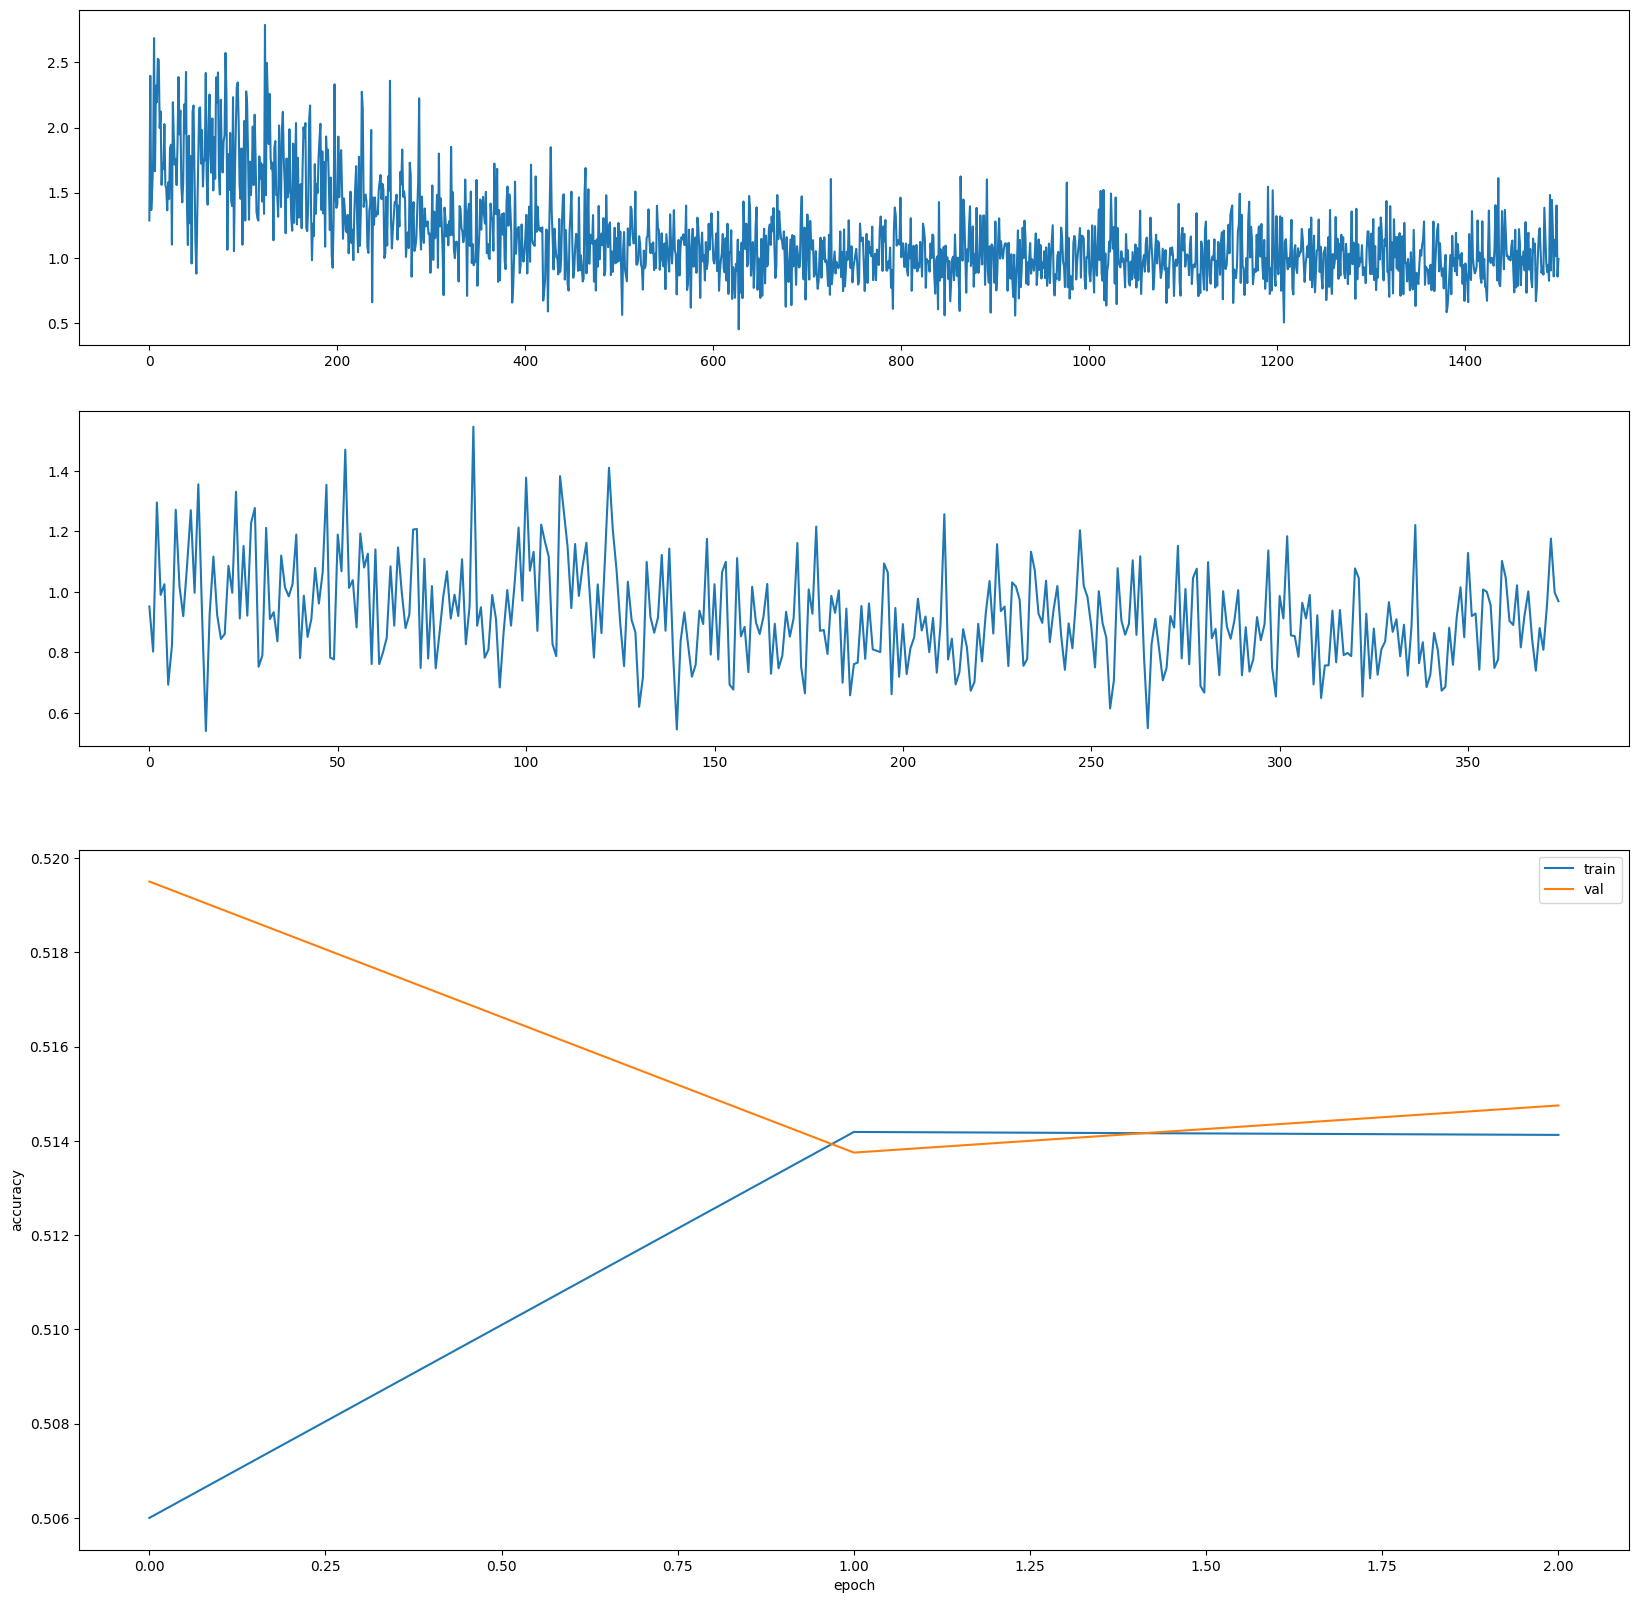

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(20,20))
a = fig.add_subplot(4, 1, 1)
b = fig.add_subplot(4, 1, 2)
c = fig.add_subplot(2, 1, 2)
a.plot(all_loss['train_loss'])
b.plot(all_loss['val_loss'])
c.plot(all_acc['train_acc'])
c.plot(all_acc['val_acc'])
c.set(xlabel='epoch', ylabel='accuracy')
c.legend(['train', 'val'])

In [ ]:
true_labels, prediction_labels, total_loss = validation(test_dataloader, device)

In [ ]:
# Calculate accuracy
accuracy = sum(1 for true, pred in zip(true_labels, prediction_labels) if true == pred) / len(true_labels)

print(f"Accuracy percentages: {accuracy * 100}")

# print(type(true_labels))


# # _, y_pred, _ = validation(test_dataloader, device)
# import numpy as np



# print("loss per batch: ", total_loss)

# # Convert softmax probabilities to predicted labels
# predicted_labels = np.argmax(prediction_labels, axis=1)

# # Calculate accuracy
# accuracy = np.mean(true_labels == predicted_labels)

# print(f"Accuracy: {accuracy}")

# # submit = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
# # submit['target'] = y_pred

# # submit.to_csv('submission.csv', index=False)

Accuracy percentages: 71.435
